In [374]:
#Importing all necessary libraries

import matplotlib.pyplot as plt
import keras
import numpy as np
import glob
import os
from PIL import Image
import tqdm

IM_WIDTH = 128
IM_HEIGHT = 128
data_samples=50  #This will help to create number of samples. 

Run the below code to remove existing folder 

In [375]:
#!rm -rf train/

Below code will make new folder called 'train'

In [376]:
os.mkdir('train')
IMG_DIR = "/content/train/"      #This is images directory.

# Generate own dataset:
Here we will generate our own dataset by using only 'Two image' and will store it 'train' folder . We need only one folder to work and will split into train-test split. Performance level gets check on test data.

Below code will generate dataset for closed image door till data_samples.

In [377]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/door.jpg')  # this is a PIL image
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `train/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/train/', save_prefix='close', save_format='jpeg'):
    i += 1
    if i >= data_samples:
        break  # otherwise the generator would loop indefinitely

Let's check number of images in train folder

In [378]:
import os

img_folder_path = '/content/train'
dirListing = os.listdir(img_folder_path)

print(len(dirListing))

50


Below code will generate dataset for open door images and will store it in train directory.

In [379]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/images.jpeg')  # this is a PIL image
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `train/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/train/', save_prefix='open', save_format='jpeg'):
    i += 1
    if i >= data_samples:
        break  # otherwise the generator would loop indefinitely

Let's check number of images in our train folder.

In [380]:
import os

img_folder_path = '/content/train/'
dirListing = os.listdir(img_folder_path)

print(len(dirListing))

99


Now it is time to import all images and resize it. Resizing is very important step because we have to keep all images size same.

In [383]:
import glob
def read_images(directory, resize_to=(IM_WIDTH, IM_HEIGHT)):
    files = glob.glob(directory + "*.jpeg")
    images = []
    labels = []
    for f in tqdm.tqdm_notebook(files):
        im = Image.open(f)
        im = im.resize(resize_to)
        im = np.array(im) / 255.0
        im = im.astype("float32")
        images.append(im)
       
        label = 1 if "open" in f.lower() else 0
        labels.append(label)
       
    return np.array(images), np.array(labels)
 
X, y = read_images(directory=IMG_DIR, resize_to=(IM_WIDTH, IM_HEIGHT))

assert len(X) == len(y) ==len(dirListing)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Let's plot some images 

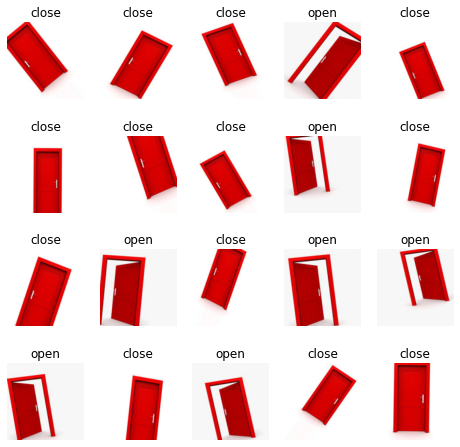

In [384]:
def plot_images(images, labels):
    n_cols = min(5, len(images))
    n_rows = len(images) // n_cols
    fig = plt.figure(figsize=(8, 8))
 
    for i in range(n_rows * n_cols):
        sp = fig.add_subplot(n_rows, n_cols, i+1)
        plt.axis("off")
        plt.imshow(images[i])
        sp.set_title(labels[i])
    plt.show()
   
def humanize_labels(labels):
    return np.where(labels == 1, "open", "close")
 
plot_images(X, humanize_labels(y))


It is time to split dataset into train-test set. Here we will use train_test_split from sklearn

In [386]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3)


Let's check the size of the train-test

In [388]:
X_train.shape, X_test.shape

((69, 128, 128, 3), (30, 128, 128, 3))

Let's plot the image of from X_train,y_train

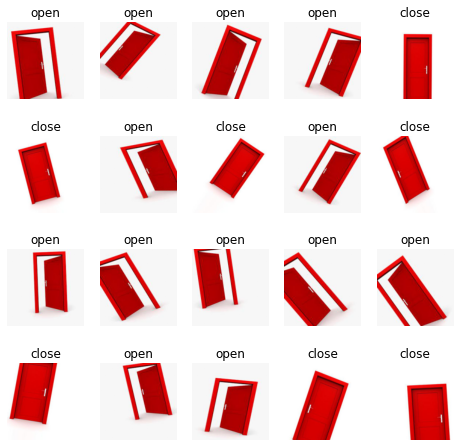

In [389]:
def plot_images(images, labels):
    n_cols = min(5, len(images))
    n_rows = len(images) // n_cols
    fig = plt.figure(figsize=(8, 8))
 
    for i in range(n_rows * n_cols):
        sp = fig.add_subplot(n_rows, n_cols, i+1)
        plt.axis("off")
        plt.imshow(images[i])
        sp.set_title(labels[i])
    plt.show()
   
def humanize_labels(labels):

    return np.where(labels == 1, "open", "close")
 
plot_images(X_train, humanize_labels(y_train))


It's is time to build CNN model by using keras.

In [390]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, MaxPool2D
from keras.models import Model
 
image_input = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = Conv2D(filters=32, kernel_size=7)(image_input)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
 
x = Conv2D(filters=64, kernel_size=3)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
 
x = Conv2D(filters=128, kernel_size=3)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=256, kernel_size=3)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
 
x = Flatten()(x)
x = Dense(units=64)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = Dense(units=1)(x)
x = Activation("sigmoid")(x)
 
model = Model(inputs=image_input, outputs=x)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 122, 122, 32)      4736      
_________________________________________________________________
activation_64 (Activation)   (None, 122, 122, 32)      0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 122, 122, 32)      128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 59, 59, 64)        18496     
_________________________________________________________________
activation_65 (Activation)   (None, 59, 59, 64)      

Fitting the model

In [391]:
model.fit(X_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
2/2 [==============================] - 0s 123ms/step - loss: 0.7947 - accuracy: 0.5217
Epoch 2/5
2/2 [==============================] - 0s 118ms/step - loss: 0.0745 - accuracy: 0.9710
Epoch 3/5
2/2 [==============================] - 0s 120ms/step - loss: 0.0438 - accuracy: 0.9855
Epoch 4/5
2/2 [==============================] - 0s 120ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 0s 120ms/step - loss: 0.0167 - accuracy: 1.0000


Let's check accuracy

In [392]:
print(model.metrics_names)
model.evaluate(X_test, y_test)


['loss', 'accuracy']
1/1 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.7667


[0.6191371083259583, 0.7666666507720947]

Let's predict on test data:

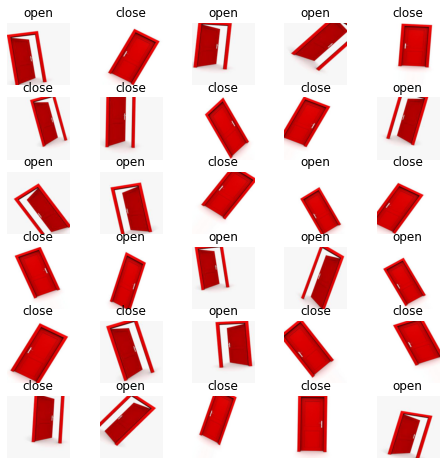

In [396]:
predictions = model.predict(X_test)
predictions = np.where(predictions.flatten() > 0.5, 1, 0)
p = np.random.permutation(len(predictions))
plot_images(X_test, humanize_labels(predictions))
